2024-08-27 16:38:04.103389: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-27 16:38:04.183827: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-27 16:38:04.183875: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-27 16:38:04.183921: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-27 16:38:04.195507: I tensorflow/core/platform/cpu_feature_g

Epoch 1/3


2024-08-27 16:38:15.319318: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-27 16:38:15.667456: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-08-27 16:38:22.638913: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x744aa4222650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-27 16:38:22.638944: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-08-27 16:38:22.645227: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-27 16:38:22.768771: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled 

200/200 [==============================] - 92s 360ms/step - loss: 0.0062 - val_loss: 0.0468 - lr: 0.0010
Epoch 2/3
200/200 [==============================] - 73s 365ms/step - loss: 0.0034 - val_loss: 0.0156 - lr: 0.0010
Epoch 3/3
200/200 [==============================] - 76s 379ms/step - loss: 0.0024 - val_loss: 0.0020 - lr: 0.0010


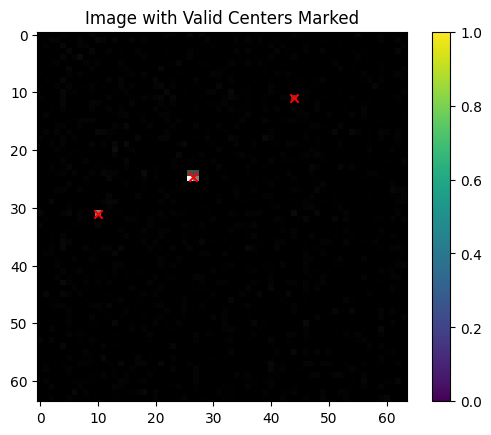

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, callbacks

class DataLoader:
    def __init__(self, h5_filename):
        self.h5_filename = h5_filename
        self.images, self.centers = self.load_data()

    def load_data(self):
        with h5py.File(self.h5_filename, 'r') as f:
            images = np.array(f['images'])
            centers = np.array(f['centers_training'])
        return images, centers

    def plot_image_with_centers(self, image_index=None):
        if image_index is None:
            image_index = np.random.randint(0, len(self.images))

        image = self.images[image_index]
        centers = self.centers[image_index]

        plt.imshow(image, cmap='gray')
        valid_centers = centers[centers[:, 0] == 1]
        for center in valid_centers:
            plt.scatter(center[1], center[2], c='red', marker='x')  # center[1] is x and center[2] is y
        plt.title('Image with Valid Centers Marked')
        plt.colorbar()
        plt.show()

    @staticmethod
    def sort_centers(centers):
        return centers[np.lexsort((centers[:, 0], centers[:, 1]))]

    def normalize_data(self):
        normalized_images = self.images / np.max(self.images)
        sorted_centers = np.array([self.sort_centers(image_centers[:, 1:]) for image_centers in self.centers])
        normalized_centers = sorted_centers / 64
        normalized_midpoints = tf.expand_dims(normalized_centers, axis=1)
        return normalized_images, normalized_midpoints.numpy()

    def split_data(self, train_size=0.8, random_state=42):
        normalized_images, normalized_midpoints_np = self.normalize_data()
        return train_test_split(normalized_images, normalized_midpoints_np, train_size=train_size, random_state=random_state)


class ModelBuilder:
    def __init__(self, input_shape=(64, 64, 1), num_classes=3, num_coordinates=2, learning_rate=1e-3):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.num_coordinates = num_coordinates
        self.learning_rate = learning_rate
        self.model = self.build_model()
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)

    def build_model(self):
        x_input = layers.Input(shape=self.input_shape)
        x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x_input)
        x = layers.MaxPool2D()(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
        
        x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)
        
        x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)
        
        x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)
        x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)
        
        x = layers.Conv2D(256, kernel_size=5, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)
        
        x = layers.Flatten()(x)
        
        x_midpoints = layers.Dense(self.num_classes * self.num_coordinates, activation='sigmoid', name='x_midpoints')(x)
        x_midpoints_reshape = layers.Reshape((-1, self.num_classes, self.num_coordinates), name='x_midpoints_reshape')(x_midpoints)
        
        return tf.keras.models.Model(x_input, x_midpoints_reshape)

    def compile_model(self, loss_function):
        self.model.compile(optimizer=self.optimizer, loss=loss_function)

    def train_model(self, train_dataset, val_dataset, epochs, callbacks_list):
        history = self.model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks_list)
        return history


@tf.keras.utils.register_keras_serializable()
class DynamicExponentCallback(tf.keras.callbacks.Callback):
    def __init__(self, initial_exponent=3, increment=1, update_frequency=10):
        super().__init__()
        self.exponent = initial_exponent
        self.increment = increment
        self.update_frequency = update_frequency

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.update_frequency == 0:
            self.exponent += self.increment
            print(f"\nEpoch {epoch + 1}: Increasing exponent to {self.exponent}")
            self.model.loss = self.custom_loss(self.exponent)

    def custom_loss(self, exponent):
        def loss(y_true, y_pred):
            diff = tf.abs(y_true - y_pred)
            powered_diff = tf.pow(diff, exponent)
            return tf.reduce_mean(powered_diff)
        return loss

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'initial_exponent': self.exponent,
            'increment': self.increment,
            'update_frequency': self.update_frequency,
        })
        return config


class CustomModelCheckpoint(callbacks.Callback):
    def __init__(self, save_freq, save_path):
        super(CustomModelCheckpoint, self).__init__()
        self.save_freq = save_freq
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            self.model.save(self.save_path.format(epoch=epoch + 1))
            print(f"Model saved at epoch {epoch + 1}")


def main():
    # Load and prepare the data
    data_loader = DataLoader('/home/m3-learning/Documents/Research Data/Electron Detection/Data Generated/100KImages_3 electrons_only.h5')
    train_images, val_images, train_midpoints, val_midpoints = data_loader.split_data()

    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
    val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))

    batch_size = 400
    train_dataset = train_dataset.shuffle(buffer_size=2000, reshuffle_each_iteration=True).batch(batch_size)
    val_dataset = val_dataset.shuffle(buffer_size=2000).batch(batch_size)

    # Build and compile the model
    model_builder = ModelBuilder()
    dynamic_exponent_callback = DynamicExponentCallback(initial_exponent=3, increment=1, update_frequency=7)
    model_builder.compile_model(loss_function=dynamic_exponent_callback.custom_loss(3))

    # Define callbacks
    save_path = "/home/da886/ElectronCountingProject/weights for custom loss/customlossmodel_epoch_{epoch:02d}.h5"
    checkpoint_callback = CustomModelCheckpoint(save_freq=200, save_path=save_path)

    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='min', min_lr=7e-15
    )

    # Train the model
    history = model_builder.train_model(
        train_dataset, val_dataset, epochs=3, callbacks_list=[dynamic_exponent_callback, lr_scheduler, checkpoint_callback]
    )

    # Optionally plot an image with its centers
    data_loader.plot_image_with_centers()


if __name__ == "__main__":
    main()


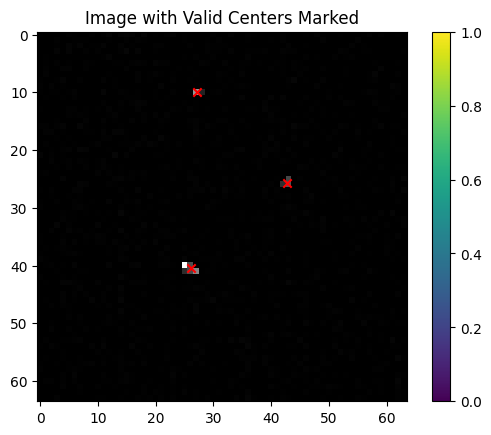

In [10]:
# Initialize the DataLoader with the path to the HDF5 file
h5_filename = '/home/m3-learning/Documents/Research Data/Electron Detection/Data Generated/100KImages_3 electrons_only.h5'
data_loader = DataLoader(h5_filename)

# Load images and centers
images, centers = data_loader.load_data()

# Optional: Plot a random image with valid centers marked
data_loader.plot_image_with_centers()


In [11]:
# Normalize the data and split it into training and validation sets
train_images, val_images, train_midpoints, val_midpoints = data_loader.split_data()

# Check the shape of the datasets
print(f'Train Images: {train_images.shape}, Train Midpoints: {train_midpoints.shape}')
print(f'Validation Images: {val_images.shape}, Validation Midpoints: {val_midpoints.shape}')


Train Images: (80000, 64, 64), Train Midpoints: (80000, 1, 3, 2)
Validation Images: (20000, 64, 64), Validation Midpoints: (20000, 1, 3, 2)


In [12]:
# Convert the data to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))

# Batch and shuffle the datasets
batch_size = 400
train_dataset = train_dataset.shuffle(buffer_size=2000, reshuffle_each_iteration=True).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=2000).batch(batch_size)


In [13]:
# Initialize the ModelBuilder
model_builder = ModelBuilder()

# Build the model
model = model_builder.build_model()

# Display the model architecture
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 64, 64, 64)        640       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 32, 32, 64)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_14 (Ba  (None, 32, 32, 64)        256       
 tchNormalization)                                               
                                                                 
 conv2d_21 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 conv2d_22 (Conv2D)          (None, 32, 32, 128)       7385

In [ ]:
# Initialize the dynamic exponent callback
dynamic_exponent_callback = DynamicExponentCallback(initial_exponent=3, increment=1, update_frequency=7)

# Compile the model with the custom loss function
model_builder.compile_model(loss_function=dynamic_exponent_callback.custom_loss(3))


In [ ]:
# Define the save path for the model checkpoints
save_path = "/home/da886/ElectronCountingProject/weights for custom loss/customlossmodel_epoch_{epoch:02d}.h5"
checkpoint_callback = CustomModelCheckpoint(save_freq=200, save_path=save_path)

# Define the learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='min', min_lr=7e-15
)


In [ ]:
# Train the model
history = model_builder.train_model(
    train_dataset, val_dataset, epochs=60, callbacks_list=[dynamic_exponent_callback, lr_scheduler, checkpoint_callback]
)


In [5]:
# Optionally, plot an image with its centers
DataLoader.plot_image_with_centers()


AttributeError: 'int' object has no attribute 'images'